In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io
import math
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
def load_2D_dataset():
    data = scipy.io.loadmat('datasets/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y.ravel(), s=40, cmap=plt.cm.Spectral);
   
    return train_X, train_Y, test_X, test_Y


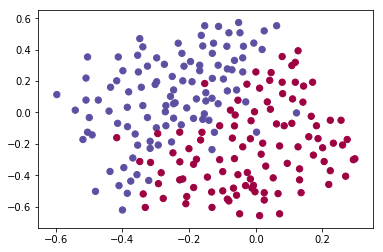

In [3]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()


In [4]:
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(2, 211)
(1, 211)
(2, 200)
(1, 200)


In [48]:
def sigmoid(Z):
    # sigmoid(Z) can be close to 1,but can not be 1.So clip Z to be 10 when Z bigger 10.
    Z[Z>=30]=30  
    Z[Z<=-30]=-30  
    A=1/(1+np.exp(-Z))
 
    return A,Z

In [49]:
A=1/(1+np.exp(-10))
print(A)
A=1/(1+np.exp(-40))
print(A)

0.9999546021312976
1.0


In [50]:
def relu(Z):
    A=np.maximum(0,Z)
   
    return A,Z

In [51]:
def initialize_parameter_deep(layer_dims):
    parameters={}
    np.random.seed(3)
    for l in range(1,len(layer_dims)):
        parameters["W"+str(l)]=np.random.randn(layer_dims[l],layer_dims[l-1])/np.sqrt(layer_dims[l-1])
        parameters["b"+str(l)]=np.zeros((layer_dims[l],1))
    
    return parameters


In [52]:
def linear_forward(A_prev,W,b):

    Z=np.dot(W,A_prev)+b
    cache=(A_prev,W,b)
    return Z,cache

In [53]:
def linear_activation_forward(A_prev,W,b,activation):
    
    if activation=="sigmoid":
        Z,linear_cache=linear_forward(A_prev,W,b)
        A,activation_cache=sigmoid(Z)
    if activation=="relu":
        Z,linear_cache=linear_forward(A_prev,W,b)
        A,activation_cache=relu(Z)
   
    cache=(linear_cache,activation_cache)
    return A,cache

In [54]:
def L_model_forward(X,parameters,keep_prob=1):
    np.random.seed(1)
    caches=[]
    dropouts=[]
    layers=len(parameters)//2
    A=X
    for l in range(1,layers):
        A_prev = A 
        A,cache=linear_activation_forward(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],"relu")
        
        #add dropout from 1 to layers-1,ignore input and output layer
        if keep_prob<1:
            dropout=np.random.rand(A.shape[0],A.shape[1])
            
            dropout=(dropout<keep_prob)
            A=(A*dropout)/keep_prob
            dropouts.append(dropout)
        caches.append(cache)
        
    AL,cache=linear_activation_forward(A,parameters["W"+str(layers)],parameters["b"+str(layers)],"sigmoid")
    caches.append(cache)
    return AL,caches,dropouts

In [55]:
def compute_cost(AL,Y,parameters,lambd=0):
    m=Y.shape[1]

    AL[AL<1e-15]=1e-15
    cost = -np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T)
    cost=np.squeeze(cost)/m
    
    L=len(parameters)//2
    R=0
    for l in range(1,L+1):
        R+=np.sum(np.square(parameters["W"+str(l)]))
    lastcost=cost+lambd*R/(2*m)
    return lastcost

In [56]:
def sigmoid_backward(dA,activation_cache):
    Z=activation_cache
    Z[Z>=30]=30  
    Z[Z<=-30]=-30
    s=1/(1+np.exp(-Z))
    dZ=dA*s*(1-s)
    return dZ

In [57]:
def relu_backward(dA,activation_cache):
    
    Z=activation_cache
    dZ=np.array(dA,copy=True)
    dZ[Z<=0]=0
    return dZ   
    

In [58]:
def linear_backward(dZ,linear_cache,lambd):
    A_prev,W,b=linear_cache
    m=A_prev.shape[1]
    
    dW=(np.dot(dZ,A_prev.T)+lambd*W)/m
    db=np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev=np.dot(W.T,dZ)
    return dA_prev,dW,db

In [59]:
def linear_activation_backward(dA,cache,activation,lambd):
    
    
    linear_cache,activation_cache=cache
   
    if activation=="sigmoid":
        dZ=sigmoid_backward(dA,activation_cache)
    elif activation=="relu":
        dZ=relu_backward(dA,activation_cache)
    dA_prev,dW,db=linear_backward(dZ,linear_cache,lambd)

    return dA_prev,dW,db

In [60]:
def L_model_backward(AL,Y,caches,dropouts,lambd=0,keep_prob=1):
    
    grads={}
    L=len(caches)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache=caches[L-1]
    grads["dA"+str(L-1)],grads["dW"+str(L)],grads["db"+str(L)]=linear_activation_backward(dAL,current_cache,"sigmoid",lambd)
    if keep_prob<1:
        grads["dA"+str(L-1)]=(grads["dA"+str(L-1)]*dropouts[L-2])/keep_prob
        #print("dA="+str(L-1)+str(grads["dA"+str(L-1)]))
    for l in reversed(range(L-1)):
        current_cache=caches[l]
        grads["dA"+str(l)],grads["dW"+str(l+1)],grads["db"+str(l+1)]=linear_activation_backward(grads["dA"+str(l+1)],current_cache,"relu",lambd)
        if keep_prob<1 and l>0:
            
            grads["dA"+str(l)]=(grads["dA"+str(l)]*dropouts[l-1])/keep_prob
           # print("dA="+str(l)+str(grads["dA"+str(l)]))
    return grads

In [61]:
def update_parameters(parameters,grads,learning_rate):
    
    L=len(parameters)//2
    
    for l in range(1,L+1):
        parameters["W"+str(l)]=parameters["W"+str(l)]-learning_rate*grads["dW"+str(l)]
        parameters["b"+str(l)]=parameters["b"+str(l)]-learning_rate*grads["db"+str(l)]
        
    return parameters

### mini_batch

In [62]:
def random_mini_batches(X,Y,mini_batch_size=64,seed=0):
    np.random.seed(seed)
    m=X.shape[1]
    mini_batchs=[]
    
    permutation=np.random.permutation(m)
    
    X_shuffled=X[:,permutation]
    Y_shuffled=Y[:,permutation].reshape((1,m))

    L=math.floor(m/mini_batch_size)
    
    for l in range(L):
        
        mini_batchs_X=X_shuffled[:,mini_batch_size*l:mini_batch_size*(l+1)]
        mini_batchs_Y=Y_shuffled[:,mini_batch_size*l:mini_batch_size*(l+1)]
        mini_batchs.append((mini_batchs_X,mini_batchs_Y))
    if L*mini_batch_size<m:
        mini_batchs_X=X_shuffled[:,mini_batch_size*L:m]
        mini_batchs_Y=Y_shuffled[:,mini_batch_size*L:m]
        mini_batchs.append((mini_batchs_X,mini_batchs_Y))
    return mini_batchs
        

In [63]:
def L_layer_model(X,Y,layers_dims,learning_rate=0.1,num_iterations=3000,print_cost=False,mini_batch_size=16,
                  grad_check=0,lambd = 0,keep_prob = 1,optimizer="gd"):
    np.random.seed(1)
    costs=[]
    parameters=initialize_parameter_deep(layers_dims)
    #mini_batch
    mini_batchs=random_mini_batches(X,Y,mini_batch_size=mini_batch_size)
    
    
    if optimizer=="gd":
        pass
    elif optimizer=="momentum":
        v=initialize_velocity(parameters)
    elif optimizer=="adam":
        v,s=initialize_adam(parameters)
        
    t=0
    for i in range(1,num_iterations+1):
        
        for mini_batch in mini_batchs:
            (mini_batch_X,mini_batch_Y)=mini_batch

            AL,caches,dropouts=L_model_forward(mini_batch_X,parameters,keep_prob)
        
            cost=compute_cost(AL,mini_batch_Y,parameters,lambd)
            grads=L_model_backward(AL,mini_batch_Y,caches,dropouts,lambd,keep_prob)
            if i<grad_check:
                gradient_check(mini_batch_X,mini_batch_Y,parameters,grads)
                
            if optimizer=="gd":
                parameters=update_parameters(parameters,grads,learning_rate)
            elif optimizer=="momentum":
                parameters,v=update_parameters_with_momentum(parameters,grads,v,beta=0.9,learning_rate=learning_rate)
            elif optimizer=="adam":
                t+=1
                parameters,v,s=update_parameters_with_adam(parameters,grads,v,s,t,learning_rate)
        if print_cost and i%1000==0:
            print("interations"+str(i)+","+str(cost))
        if print_cost and i%500==0:
            costs.append(cost)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    return parameters
            

In [64]:
def predict(X,y,parameters,):

    AL,caches,dropouts=L_model_forward(X,parameters)
    m=X.shape[1]
    yhat=np.round(AL)
    
    print("Accuracy:"+str(np.sum(yhat==y)/m))
    return yhat

### grad check

In [65]:
def parameters_to_vectors(parameters):
    """
    dictionary to vector
    t: d:gradient,""
    parameters: dictionary
    
    """       
    L=len(parameters)//2
    parameter_vector=np.array([[]])
    for l in range(1,L+1):
        W=parameters["W"+str(l)]
        b=parameters["b"+str(l)]
        parameter_vector=np.hstack((parameter_vector,np.reshape(W,(1,-1))))
        parameter_vector=np.hstack((parameter_vector,np.reshape(b,(1,-1))))
    
    return parameter_vector

In [66]:
def grads_to_vectors(grads):
    """
    dictionary to vector
    t: d:gradient,""
    parameters: dictionary
    
    """       
    L=len(grads)//3
    grads_vector=np.array([[]])
    for l in range(1,L+1):
        W=grads["dW"+str(l)]
        b=grads["db"+str(l)]
        grads_vector=np.hstack((grads_vector,np.reshape(W,(1,-1))))
        grads_vector=np.hstack((grads_vector,np.reshape(b,(1,-1))))
    return grads_vector

In [67]:
def vector_to_dic(parameters,vector):
    
    dic={}
    L=len(parameters)//2
    begin=0
    for t in range(1,L+1):
        w=parameters["W"+str(t)]
        b=parameters["b"+str(t)]

        dic["W"+str(t)]=np.reshape(vector[:,begin:begin+w.shape[0]*w.shape[1]],(w.shape[0],w.shape[1]))
        begin+=w.shape[0]*w.shape[1]

        dic["b"+str(t)]=np.reshape(vector[:,begin:begin+b.shape[0]*b.shape[1]],(b.shape[0],b.shape[1]))
        begin+=b.shape[0]*b.shape[1]

    return dic

In [68]:
def diffence(grad,gradapprox,epsilon):
    numerator=np.linalg.norm(grad-gradapprox)
    denominator=np.linalg.norm(grad)+np.linalg.norm(gradapprox)
    diff=numerator/denominator
    if diff<1e-7:
        print("The gradient is correct!,and diff is :"+str(diff))
    else:
        print("The gradient is wrong!")

In [69]:
def gradient_check(X,y,parameters,grads,epsilon=1e-7):
    
    parameters_vector=parameters_to_vectors(parameters)
    
    grads_vector=grads_to_vectors(grads)
    gradapprox=[]
    for i in range (parameters_vector.shape[1]):
        
        theta_plus=np.copy(parameters_vector)
        theta_plus[0][i]+=epsilon
        
        AL,caches,dropouts=L_model_forward(X,vector_to_dic(parameters,theta_plus))
        J_plus=compute_cost(AL,y,vector_to_dic(parameters,theta_plus))
        
        theta_minus=np.copy(parameters_vector)
        theta_minus[0][i]-=epsilon
        AL,caches,dropouts=L_model_forward(X,vector_to_dic(parameters,theta_minus))
        J_minus=compute_cost(AL,y,vector_to_dic(parameters,theta_minus))
        gradapprox.append((J_plus-J_minus)/(2*epsilon))
    diffence(grads_vector,gradapprox,epsilon)

### Momentum

In [70]:
def initialize_velocity(parameters):
    
    L=len(parameters)//2
    v={}
    for l in range(L):
        v["dW"+str(l+1)]=np.zeros(parameters["W"+str(l+1)].shape)
        v["db"+str(l+1)]=np.zeros(parameters["b"+str(l+1)].shape)
    return v

In [71]:
def update_parameters_with_momentum(parameters,grads,v,beta,learning_rate):
    L=len(parameters)//2
    for l in range(L):
        v["dW"+str(l+1)]=beta*v["dW"+str(l+1)]+(1-beta)*grads["dW"+str(l+1)]
        parameters["W"+str(l+1)]=parameters["W"+str(l+1)]-learning_rate*v["dW"+str(l+1)]
        v["db"+str(l+1)]=beta*v["db"+str(l+1)]+(1-beta)*grads["db"+str(l+1)]
        parameters["b"+str(l+1)]=parameters["b"+str(l+1)]-learning_rate*v["db"+str(l+1)]
    return parameters,v
        

### Adam

In [72]:
def initialize_adam(parameters):
    L=len(parameters)//2
    v={}
    s={}
    for l in range(L):
        v["dW"+str(l+1)]=np.zeros(parameters["W"+str(l+1)].shape)
        v["db"+str(l+1)]=np.zeros(parameters["b"+str(l+1)].shape)
        s["dW"+str(l+1)]=np.zeros(parameters["W"+str(l+1)].shape)
        s["db"+str(l+1)]=np.zeros(parameters["b"+str(l+1)].shape)
    return v,s

In [73]:
def update_parameters_with_adam(parameters,grads,v,s,t,learning_rate=0.01,beta1=0.9,beta2=0.999,epsilon=1e-8):
    L=len(parameters)//2
    v_correct={}
    s_correct={}
    
    for l in range(L):
        v["dW"+str(l+1)]=beta1*v["dW"+str(l+1)]+(1-beta1)*grads["dW"+str(l+1)]
        
        v_correct["dW"+str(l+1)]=v["dW"+str(l+1)]/(1-math.pow(beta1,t))
        v["db"+str(l+1)]=beta1*v["db"+str(l+1)]+(1-beta1)*grads["db"+str(l+1)]
        v_correct["db"+str(l+1)]=v["db"+str(l+1)]/(1-math.pow(beta1,t))
        
        s["dW"+str(l+1)]=beta2*s["dW"+str(l+1)]+(1-beta2)*(grads["dW"+str(l+1)]**2)
        #print(1-math.pow(beta2,t))
        s_correct["dW"+str(l+1)]=s["dW"+str(l+1)]/(1-math.pow(beta2,t))
       
        s["db"+str(l+1)]=beta2*s["db"+str(l+1)]+(1-beta2)*(grads["db"+str(l+1)]**2)
        s_correct["db"+str(l+1)]=s["db"+str(l+1)]/(1-math.pow(beta2,t))
        
        parameters["W"+str(l+1)]=parameters["W"+str(l+1)]-learning_rate*v_correct["dW"+str(l+1)]/(np.sqrt(s["dW"+str(l+1)])+epsilon)
        parameters["b"+str(l+1)]=parameters["b"+str(l+1)]-learning_rate*v_correct["db"+str(l+1)]/(np.sqrt(s["db"+str(l+1)])+epsilon)
    return parameters,v,s
    

### Train model runing...

In [31]:
layers_dims=[2,20,3,1]

interations1000,2.4638365277791103
interations2000,2.3573133423339265
interations3000,2.3342040609088066
interations4000,2.2778200487465465
interations5000,2.269690753854249
interations6000,2.2161092893054657
interations7000,2.1538283337612065
interations8000,2.1121459020928506
interations9000,2.0037721410979303
interations10000,1.787412934871923


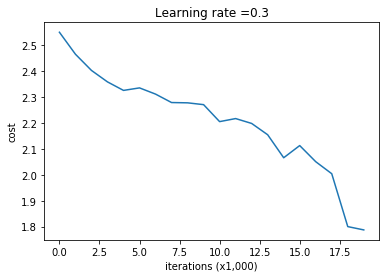

Accuracy:0.943127962085308
Accuracy:0.955


In [38]:
parameters=L_layer_model(train_X,train_Y,layers_dims,learning_rate=0.3,num_iterations=10000,print_cost=True,keep_prob=1,optimizer="momentum")
pred_train = predict(train_X, train_Y, parameters)
pred_test = predict(test_X, test_Y, parameters)

interations1000,0.02745347705166277


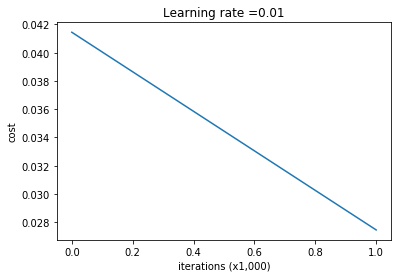

Accuracy:0.966824644549763
Accuracy:0.925


In [75]:
parameters=L_layer_model(train_X,train_Y,layers_dims,learning_rate=0.01,mini_batch_size=64,num_iterations=1000,print_cost=True,keep_prob=1,optimizer="adam")
pred_train = predict(train_X, train_Y, parameters)
pred_test = predict(test_X, test_Y, parameters)